In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import scipy.fft as spft
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import torch
import torch.fft as fft
from torch import nn

In [3]:
def fetch_data(file,datacols,cuts,setdevs):

    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset


In [4]:
def load_BPMphase_data_single(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            #26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cavs[i][2:]])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x +360)

        dfs.append(df)

    return dfs


In [5]:
def load_BPMphase_data_multi(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cav[2:] for cav in cavs])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                   df[col] = df[col].apply(lambda x : x if x > 0 else x +360)


        dfs.append(df)

    return dfs


In [6]:
def fft_array(array):
    array = torch.tensor(array, dtype=torch.float32)
    fft_vals = fft.fft(array)
    N = len(array)
    freq = fft.fftfreq(N)
    return freq, fft_vals

def apply_FFT(ddfs):
    raw_ffts = []
    for j in range(len(ddfs)):
        fft_df = ddfs[j].copy(deep=True)
        for current_device in ddfs[j].columns:
            freq, fft_vals = fft_array(ddfs[j][current_device].values)
            fft_df[current_device] = torch.abs(fft_vals).numpy()
            fft_df[f'freq_{current_device}'] = freq.numpy()
        raw_ffts.append(fft_df)
    return raw_ffts

def apply_FFT_filter(df, cavs, BPM_list, tolerance=0.0005):
    ddfs2 = []
    BPMs = list(set(BPM_list).intersection(set(list(df.columns))))
    for j in range(len(cavs)):
        current_df = df.copy(deep=True)
        freq_driving, fft_vals_driving = fft_array(df[cavs[j]].values)
        filter_freqs = freq_driving[torch.argmax(torch.abs(fft_vals_driving))]
        for current_device in BPMs:
            freq, fft_vals = fft_array(df[current_device].values)
            fft_vals2 = torch.zeros_like(fft_vals)
            mask = torch.abs(torch.abs(freq) - filter_freqs) < tolerance
            fft_vals2[mask] = fft_vals[mask]
            current_df[current_device] = torch.real(fft.ifft(fft_vals2)).numpy()
        ddfs2.append(current_df)
    return ddfs2

In [7]:
def plot_fft(fft_data,devices,npt,nperiods):
    #%matplotlib widget
    %matplotlib inline
    for dev in devices:
        #plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='o')
        markerline, stemlines, baseline = plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='.')
        plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
        plt.setp(baseline, 'color', plt.getp(markerline,'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')


    plt.xlim(0,100)
    plt.ylim(0,6)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude (deg)')
    plt.grid()
    plt.legend(loc='upper right')

In [63]:
def calc_errors(fft_data, devices, npt, nperiods):
    for dev in devices:
        idx_noise = torch.where((fft_data[f'freq_{dev}'] > 0.1) & (fft_data[f'freq_{dev}'] < 0.2))
        noise = torch.mean(torch.tensor(fft_data[dev].iloc[idx_noise].values))

def calc_response_matrix(dfs, cavs):
    final_response_matrix = []
    for j in range(len(dfs)):
        slice_pos = torch.argmax(torch.tensor(dfs[j][cavs[j]].values)).item()
        norm_val = dfs[j][cavs[j]].iloc[slice_pos]
        final_response_matrix.append(dfs[j].iloc[slice_pos] / norm_val)
    return final_response_matrix

class DeepNN(nn.Module):
    def __init__(self, input_dim,output_dim):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, X):
        return self.model(X)

def linear_fit_to_basis(osc_array, *b_vecs):
    X = torch.stack(b_vecs, dim=1)
    if not isinstance(osc_array, torch.Tensor):
      osc_array = torch.tensor(osc_array, dtype=torch.float32)
    if osc_array.ndim == 1:
        osc_array = osc_array.unsqueeze(1)
    model = DeepNN(X.shape[1],1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.L1Loss()
    for _ in range(50000):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, osc_array)
        loss.backward()
        optimizer.step()
    return model.model[0].weight.detach().numpy()[0],model.model[0].bias.detach().numpy()[0]

In [10]:
###  BASIS SELECTION
def select_basis(final_response_matrix,basis_choice_override):

    #basis_choice_override = (0, 1) #whether to autoselect basis or not
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 7))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    basis_choice = possible_basis[np.argmin(np.abs(overlaps))]

    if basis_choice_override != None: basis_choice = basis_choice_override

    return basis_choice

In [34]:
####  DIAGNOSTICS

def show_basis_choices(final_response_matrix):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    for i in range(len(possible_basis)): print(possible_basis[i], overlaps[i])
    return None

def plot_tank_fit(cavs,target_index, basis, response_matrix):
    target = response_matrix[target_index]

    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target[idx:], response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(target[idx:], label = '%s'%cavs[target_index])
    plt.plot(coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.4f * T{basis[0]} + %.4f * T{basis[1]}"%tuple(coefs))
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xticks(rotation = 90)
    plt.xlabel("Distance, m")
    plt.legend()
    return None

def plot_fit_traj(cavs,target_trajectory, basis, response_matrix,targetlbl=None):
    if targetlbl:
        target = str(targetlbl)
    else:
        target='Target trajectory'
    idx = len(response_matrix)
    if len(basis)!=7:
        raise ValueError('The basis length must be 7')
    tensor_b_vecs = [torch.tensor(response_matrix[b][idx:].values, dtype=torch.float32) for b in basis]
    target_tensor = torch.tensor(target_trajectory.values, dtype=torch.float32)
    coefs,bias = linear_fit_to_basis(target_tensor, *tensor_b_vecs)

    plt.plot(dist_data,target_trajectory, label = target)
    fit_line = 0
    for i in range(len(basis)):
        fit_line += coefs[i] * response_matrix[basis[i]][idx:]
    fit_line += bias
    label = " + ".join([f"{coefs[i]:.2f} * {cavs[basis[i]]}" for i in range(len(basis))])
    plt.plot(dist_data,fit_line, label = label)
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xlabel("Distance, m")
    plt.legend(loc='upper right')
    return None


def plot_basis_vectors(response_matrix,cavs,show):
    cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in response_matrix]
    for index in show:
        plt.plot(dist_data, response_matrix[index][:], label = '%s'%cavnames[index])
    plt.legend(loc='upper right',ncol=2)
    plt.xlabel("Distance, m")
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    #plt.ylim(-0.45, 0.45)
    plt.ylim(-3.5,3.5)
    plt.grid()
    plt.show()

    return None


In [12]:
### Load BPM location data
json_file = open('/content/drive/MyDrive/PhaseCompensation/sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = [ 'L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] #remove DTL part & D44 noisy

for device in devices_to_drop:
    try:
        del BPM_positions[device]
    except:
        continue

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)

['L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF', 'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF']


In [13]:
print(BPM_positions)

{'L:D02BF': 80.4, 'L:D03BF': 80.9, 'L:D11BF': 83.7, 'L:D12BF': 85.4, 'L:D13BF': 87.1, 'L:D21BF': 90.5, 'L:D22BF': 92.3, 'L:D23BF': 94.2, 'L:D31BF': 98.1, 'L:D32BF': 100.1, 'L:D33BF': 102.2, 'L:D34BF': 104.2, 'L:D41BF': 106.3, 'L:D42BF': 108.5, 'L:D43BF': 110.6, 'L:D51BF': 115.1, 'L:D52BF': 117.3, 'L:D53BF': 119.6, 'L:D54BF': 121.9, 'L:D61BF': 124.3, 'L:D62BF': 126.7, 'L:D63BF': 129.1, 'L:D64BF': 131.5, 'L:D71BF': 133.9, 'L:D72BF': 136.4, 'L:D73BF': 138.9, 'L:D74BF': 141.4}


In [14]:
# Define filepath and scanned cavities
filepath = r"/content/drive/MyDrive/PhaseCompensation/"

# Cavity colloquial names (for plot labeling)
cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
# Phase setting - this is the control knob
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
# Phase readback - data from physical phase pickups. Discrepances between the two are sign of mis- or under- regulation
cavs_read = ['L:V%iSQ'%n for n in range(1,6)]
# Combined list
cavs_both = cavs + cavs_read

In [15]:
# Reference file: this is used to calculate the fit basis

ref_file = r'%s20240229_143636_AllTanks.csv'%filepath
#ref_file = r'%s2024_02_15_1200.csv'%filepath
#ref_file = r'%s20240410_150201.csv'%filepath

reference = load_BPMphase_data_multi(cavs_both,[ref_file],devices_to_drop,scan=True)
reference = [df - df.mean() for df in reference] # mean - for zero peak suppression in FFT


In [16]:
reference[0].columns

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET',
       'L:V5QSET', 'L:V1SQ', 'L:V2SQ', 'L:V3SQ', 'L:V4SQ', 'L:V5SQ', 'L:D02BF',
       'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF',
       'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF',
       'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF',
       'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF',
       'L:D73BF', 'L:D74BF'],
      dtype='object')

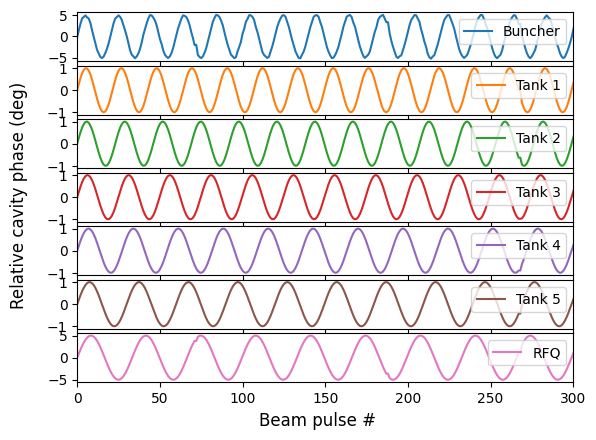

In [17]:
# For demonstration: how are we changing cavity phases?
# Oscillating them all together in sinewaves with different frequencies
%matplotlib inline
fig,ax = plt.subplots(7,sharex=True)
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

for i, cav in enumerate(cavs[:7]):
    ax[i].plot(reference[0][cav],label='%s'%cavnames[i],c=colors[i])
    ax[i].legend(loc='upper right',bbox_to_anchor=(1,1))
    ax[i].set_xlim(0,300)

fig.supxlabel('Beam pulse #')
fig.supylabel('Relative cavity phase (deg)')
plt.subplots_adjust(wspace=0, hspace=0.1)

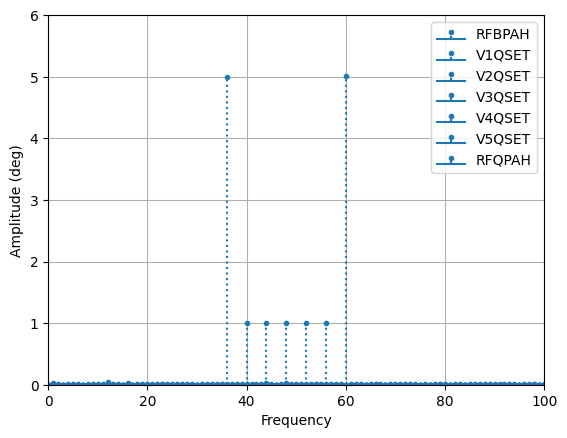

In [18]:
# Sanity check in Fourier space: are cavity phases oscillating at the desired frequencies and amplitudes?
raw_ffts = apply_FFT(reference)

Nper = 4
Npt = 299
plot_fft(raw_ffts[0],cavs,Npt,Nper)

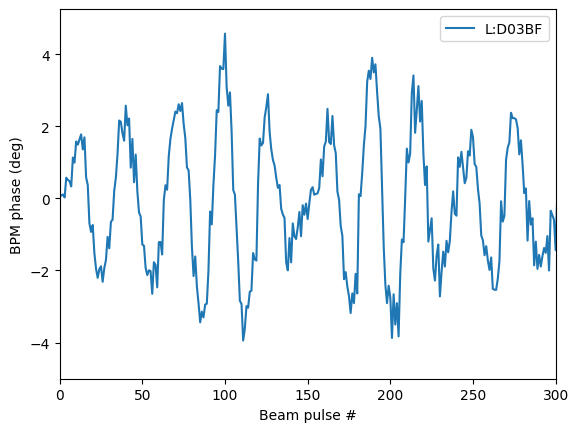

In [19]:
# For demonstration purposes.
# What does the beam phase combined response look like? It is the combined effect of 7 cavities oscillating
# L:D03BF is the data from one sensor
plt.plot(reference[0]['L:D03BF'],label='L:D03BF')
#plt.plot(dfs[0]['L:D12BF'],label='L:D12BF') # different location
plt.xlim(0,300)
plt.xlabel('Beam pulse #')
plt.ylabel('BPM phase (deg)')
plt.legend()

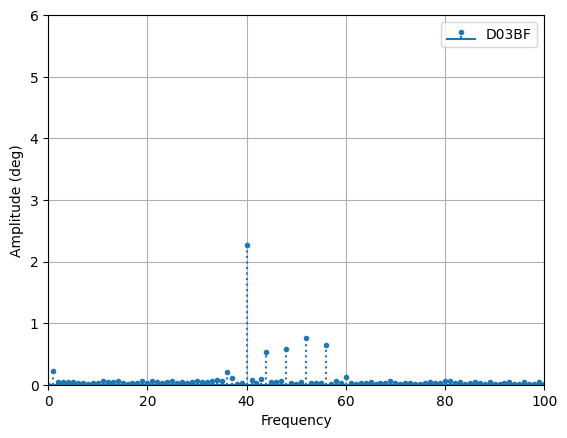

In [20]:
# And here is the response in Fourier space.
# We see 7 peaks corresponding to the 7 cavities + noise
plot_fft(raw_ffts[0],['L:D03BF'],Npt,Nper)

In [21]:
# select only relevant columns from dataframe
reference[0] = reference[0][cavs+BPM_list]
reference[0].columns

Index(['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET',
       'L:RFQPAH', 'L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF',
       'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF',
       'L:D34BF', 'L:D41BF', 'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF',
       'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF',
       'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF'],
      dtype='object')

In [22]:
# Calculate and plot response matrix: how beam phase changes in response to cavity phase change
refs = apply_FFT_filter(reference[0],cavs,BPM_list,tolerance=0.0001)
response_matrix = calc_response_matrix(refs,cavs)

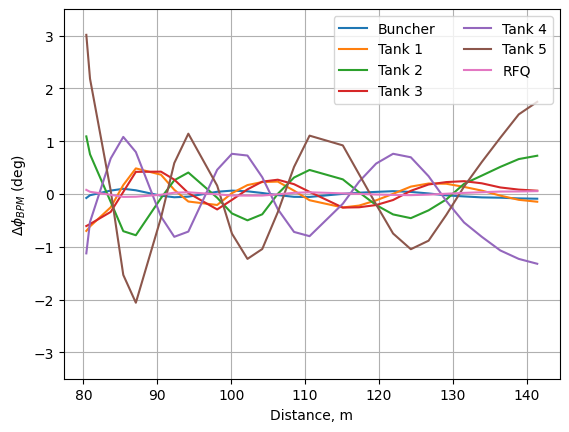

In [23]:
%matplotlib inline
response_matrix_bpm = [r[BPM_list] for r in response_matrix]
plot_basis_vectors(response_matrix_bpm,cavs,range(len(response_matrix_bpm)))

In [24]:
# Select 2 basis vectors out of the 7
show_basis_choices(response_matrix_bpm)
#basis_choice = select_basis(response_matrix_bpm,basis_choice_override=(0,1))
# we can force the choice of basis vectors. If not forced, it will look for "orthogonality" (see function body)
basis_choice = select_basis(response_matrix_bpm,basis_choice_override=None)
# basis_choice=(1,3)

(0, 1) 0.2652983544906456
(0, 2) -0.8683836829642168
(0, 3) -0.14570015018823404
(0, 4) 0.9861924642242741
(0, 5) -0.7651170995441031
(0, 6) -0.8991281080922735
(1, 2) -0.6957492240136764
(1, 3) 0.9083621957099772
(1, 4) 0.34483870476703166
(1, 5) -0.8160941057873199
(1, 6) -0.6407444959757235
(2, 3) -0.3460615351674245
(2, 4) -0.9113747768012356
(2, 5) 0.98051342448257
(2, 6) 0.9814399067528565
(3, 4) -0.0681131121466905
(3, 5) -0.5077657979541684
(3, 6) -0.2798153805287206
(4, 5) -0.8227578867543179
(4, 6) -0.920984134413479
(5, 6) 0.9512766698520375


In [25]:
print(basis_choice)

(0, 1, 2, 3, 4, 5, 6)


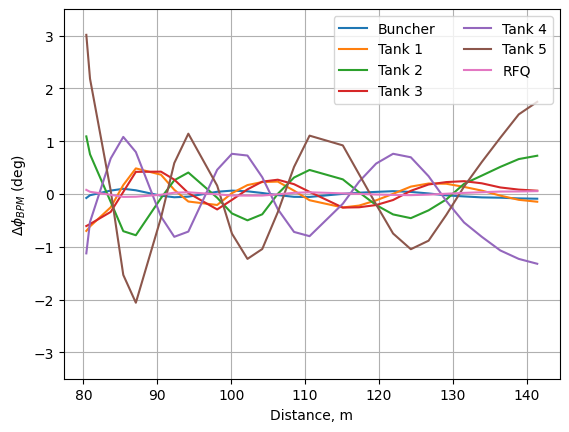

In [26]:
# Sanity check
plot_basis_vectors(response_matrix_bpm,cavs,list(basis_choice))

In [27]:
### Fitting with basis vectors demonstration
# Below we show several tests of the 2-vector fitting

# Test 1: 1-step drift compensation
# Fitting data from Feb 15 and Feb21 to return to Feb 08 state
# Reference file: Feb 29 (I think?)
path = "/content/drive/MyDrive/PhaseCompensation/"
dates = ["20240208_","20240215_","20240215_","20240221_","20240221_"]
times = ["163623_nominal",'143017_nominal2',
         "155508_dailyCorrFeb8_positive","161542_nominal2","162307_dailyCorrFeb8_negative2"]
files = ['%s%s%s.csv'%(path,d,t) for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Feb 15 relative','Feb 15 corrected','Feb 21 relative','Feb 21 corrected']


'''
# Test 2: 1-step compensation of upstream fluctuation
# Reference file Feb 15
date="20240215_"
lbls = ['Nominal','RFQ +15deg','RFQ Compensated','T1+4deg','T1 Compensated']
times = ['132713_nominal_1000evt','133256_RFQplus15deg','134353_FullyCompensatedT4T5',
         '143412_T1plus4deg','144019_T1FullyCompensatedT4T5']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]


# Test 3: multi-step compensation of upstream fluctuations
# Reference file April 10
date = '20240410_'
lbls = ['Nominal','Buncher+20deg','Compensated step 1','Step 2','Step 3','Step 4']
times = ['151457','152154','155113','160055','160739','161432']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]
'''

dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)


In [28]:
means = [df[BPM_list].mean() for df in dfs]
stds = [df[BPM_list].std() for df in dfs] #normalized by N-1. Use ddof=0 to normalize by N
#should I be using SEM instead of STD?

In [29]:
# Calculate difference from nominal
diffs = [m - means[0] for m in means]
errs = [np.sqrt(s**2 + stds[0]**2) for s in stds]

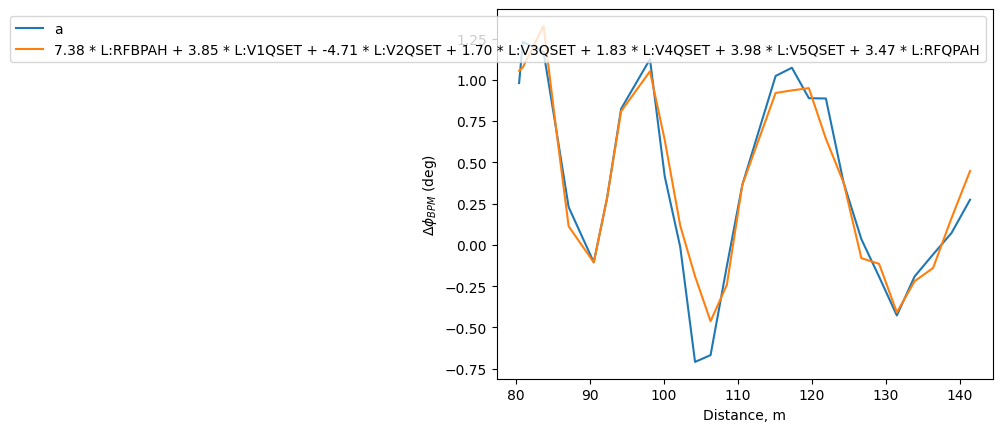

In [64]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

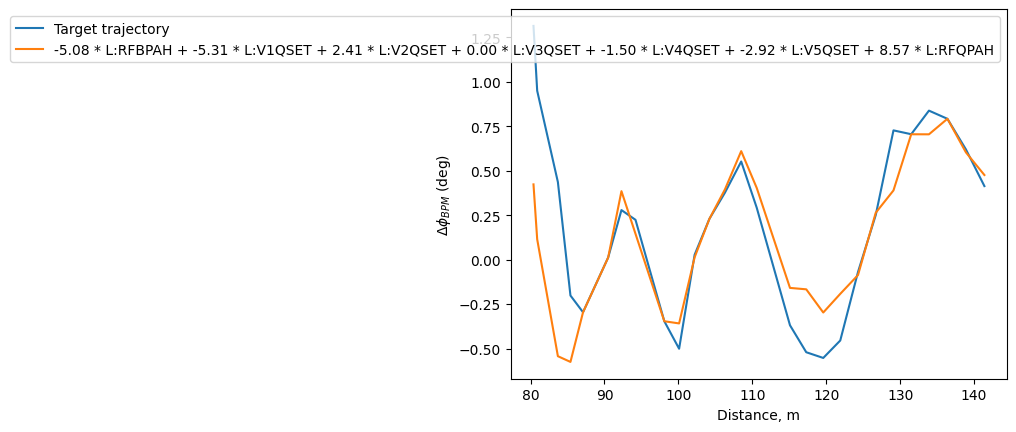

In [65]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [37]:
# Metrics
for i,(diff,err) in enumerate(zip(diffs,errs)):
    print(r'%s mean'%lbls[i],diff.mean())
    print(r'%s STD'%lbls[i],diff.std())
    print(r'%s err'%lbls[i],err.mean())
    print(r'%s err/sqrt(N)'%lbls[i],err.mean()/np.sqrt(dfs[i].shape[0]))

Feb 08 nominal mean 0.0
Feb 08 nominal STD 0.0
Feb 08 nominal err 0.492983325064769
Feb 08 nominal err/sqrt(N) 0.015597302158595961
Feb 15 relative mean 0.3502481159544916
Feb 15 relative STD 0.5764942064061145
Feb 15 relative err 0.5076131662988342
Feb 15 relative err/sqrt(N) 0.016060169851392716
Feb 15 corrected mean 0.2922739695261665
Feb 15 corrected STD 0.3107970612688756
Feb 15 corrected err 0.5035463868011051
Feb 15 corrected err/sqrt(N) 0.015923534898396402
Feb 21 relative mean -0.007184648637899011
Feb 21 relative STD 1.3666226788948868
Feb 21 relative err 0.5263273684654922
Feb 21 relative err/sqrt(N) 0.016643932792336374
Feb 21 corrected mean 0.21223127424299232
Feb 21 corrected STD 0.5084061826662281
Feb 21 corrected err 0.5194840182816093
Feb 21 corrected err/sqrt(N) 0.016435746987254227


(-4.0, 4.0)

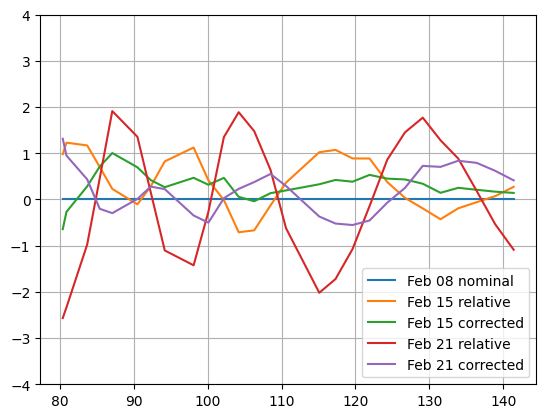

In [38]:
#%matplotlib widget
#[plt.errorbar(dist_data,diff,yerr=err,label=lbls[i]) for i,(diff,err) in enumerate(zip(diffs,errs))];
[plt.plot(dist_data,diff,label=lbl) for (diff,lbl) in zip(diffs[:],lbls[:])];
plt.legend()
plt.grid()
plt.ylim(-4,4)

In [ ]:
# RL Agent for tuning alpha
class AlphaTuningAgent(nn.Module):
    def __init__(self, state_dim, hidden_dim=32):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output ∈ (0,1) -> scale it to desired alpha range
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=1e-3)

    def get_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        alpha = self.actor(state_tensor) * 0.5  # scale (0, 0.5)
        return alpha.squeeze().item()

    def train_step(self, state, reward):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float32)

        value = self.critic(state_tensor)
        value_loss = nn.MSELoss()(value, reward_tensor)

        alpha = self.actor(state_tensor)
        actor_loss = -reward_tensor * alpha

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        self.critic_opt.zero_grad()
        value_loss.backward()
        self.critic_opt.step()

        return actor_loss.item(), value_loss.item()

def fetch_data(file, datacols, cuts, setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:, cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')), axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset

def load_BPMphase_data_single(cavs, files, dropdevs, scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file, cavs+['BF','BPM','SQ'], '', [f'{cavs[i][2:]}_S'])
        else:
            df = fetch_data(file, cavs+['BF','BPM','SQ'], '', [])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))), axis=1)
        except:
            continue
        # deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min() - df[col].max()) > 350:
                if np.sign(df[col]).mean() < 0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x - 360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x + 360)
        dfs.append(df)
    return dfs

def load_BPMphase_data_multi(cavs, files, dropdevs, scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            df = fetch_data(file, cavs+['BF','BPM','SQ'], '', [f'{cav[2:]}_S' for cav in cavs])
        else:
            df = fetch_data(file, cavs+['BF','BPM','SQ'], '', [])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))), axis=1)
        except:
            continue
        # deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max()) > 350:
                if np.sign(df[col]).mean() < 0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x - 360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x + 360)
        dfs.append(df)
    return dfs

def fft_array(array):
    array = torch.tensor(array, dtype=torch.float32)
    fft_vals = fft.fft(array)
    N = len(array)
    freq = fft.fftfreq(N)
    return freq, fft_vals

def apply_FFT(ddfs):
    raw_ffts = []
    for j in range(len(ddfs)):
        fft_df = ddfs[j].copy(deep=True)
        for current_device in ddfs[j].columns:
            freq, fft_vals = fft_array(ddfs[j][current_device].values)
            fft_df[current_device] = torch.abs(fft_vals).numpy()
            fft_df[f'freq_{current_device}'] = freq.numpy()
        raw_ffts.append(fft_df)
    return raw_ffts

def apply_FFT_filter(df, cavs, BPM_list, tolerance=0.0005):
    ddfs2 = []
    BPMs = list(set(BPM_list).intersection(set(list(df.columns))))
    for j in range(len(cavs)):
        current_df = df.copy(deep=True)
        freq_driving, fft_vals_driving = fft_array(df[cavs[j]].values)
        filter_freqs = freq_driving[torch.argmax(torch.abs(fft_vals_driving))]
        for current_device in BPMs:
            freq, fft_vals = fft_array(df[current_device].values)
            fft_vals2 = torch.zeros_like(fft_vals)
            mask = torch.abs(torch.abs(freq) - filter_freqs) < tolerance
            fft_vals2[mask] = fft_vals[mask]
            current_df[current_device] = torch.real(fft.ifft(fft_vals2)).numpy()
        ddfs2.append(current_df)
    return ddfs2

def plot_fft(fft_data, devices, npt, nperiods):
    for dev in devices:
        markerline, stemlines, baseline = plt.stem(
            fft_data[f'freq_{dev}'] * npt * nperiods,
            fft_data[f'{dev}'] * 2/(npt*nperiods),
            label=f'{dev[2:]}', markerfmt='.'
        )
        plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
        plt.setp(baseline, 'color', plt.getp(markerline,'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')

    plt.xlim(0,100)
    plt.ylim(0,6)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude (deg)')
    plt.grid()
    plt.legend(loc='upper right')

def calc_errors(fft_data, devices, npt, nperiods):
    for dev in devices:
        idx_noise = torch.where(
            (fft_data[f'freq_{dev}'] > 0.1) & (fft_data[f'freq_{dev}'] < 0.2)
        )
        noise = torch.mean(torch.tensor(fft_data[dev].iloc[idx_noise].values))

def calc_response_matrix(dfs, cavs):
    final_response_matrix = []
    for j in range(len(dfs)):
        slice_pos = torch.argmax(torch.tensor(dfs[j][cavs[j]].values)).item()
        norm_val = dfs[j][cavs[j]].iloc[slice_pos]
        final_response_matrix.append(dfs[j].iloc[slice_pos] / norm_val)
    return final_response_matrix

class DeepNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, X):
        return self.model(X)

def linear_fit_to_basis(osc_array, *b_vecs):
    X = torch.stack(b_vecs, dim=1)
    if not isinstance(osc_array, torch.Tensor):
        osc_array = torch.tensor(osc_array, dtype=torch.float32)
    if osc_array.ndim == 1:
        osc_array = osc_array.unsqueeze(1)
    model = DeepNN(X.shape[1], 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.L1Loss()
    for _ in range(50000):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, osc_array)
        loss.backward()
        optimizer.step()
    return model.model[0].weight.detach().numpy()[0], model.model[0].bias.detach().numpy()[0]

def select_basis(final_response_matrix, basis_choice_override):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 7))
    e_normed_response = [rm/np.linalg.norm(rm) for rm in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]
    basis_choice = possible_basis[np.argmin(np.abs(overlaps))]

    if basis_choice_override is not None:
        basis_choice = basis_choice_override

    return basis_choice

def show_basis_choices(final_response_matrix):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [rm/np.linalg.norm(rm) for rm in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    for i in range(len(possible_basis)):
        print(possible_basis[i], overlaps[i])
    return None

def plot_tank_fit(cavs, target_index, basis, response_matrix):
    target = response_matrix[target_index]
    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target[idx:], response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(target[idx:], label=f'{cavs[target_index]}')
    plt.plot(coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:],
             label=f"{coefs[0]:.4f} * T{basis[0]} + {coefs[1]:.4f} * T{basis[1]}")
    plt.ylabel(r"$ \Delta \phi_{\mathrm{BPM}}$ (deg)")
    plt.xticks(rotation=90)
    plt.xlabel("Distance, m")
    plt.legend()
    return None

def plot_fit_traj(cavs, target_trajectory, basis, response_matrix, dist_data, targetlbl=None):
    """
    Option B: Slices everything consistently so the shapes match.

    Args:
        cavs: list of cavity names (for labeling).
        target_trajectory: Pandas Series (or DataFrame row) with shape (N_points,).
        basis: tuple/list of indices specifying which cavities in 'response_matrix' form the basis.
        response_matrix: list of length M (e.g., M=7).
                        Each element is a DataFrame or Series for one cavity's effect on BPMs.
        dist_data: list or array of length N_points, for BPM distances or indices.
        targetlbl: optional label for the legend.
    """
    # The code above uses 'idx = len(response_matrix)' to skip the first 'len(response_matrix)' rows.
    idx = len(response_matrix)

    # 1) Slice the target trajectory so it starts from the same row as 'idx'
    #    Make sure 'target_trajectory' is a Pandas Series (or convert it).
    target_sub = target_trajectory.iloc[idx:]  # same dimension after skip

    # 2) Slice the distance array
    dist_sub = dist_data[idx:]  # skip the same number of points

    # 3) Convert the basis vectors from the response_matrix,
    #    also skipping 'idx' rows so they match 'target_sub' length
    tensor_b_vecs = []
    for b in basis:
        # 'response_matrix[b]' is presumably a Series or DataFrame of shape (N_points,).
        b_sub = response_matrix[b].iloc[idx:]
        tensor_b_vecs.append(torch.tensor(b_sub.values, dtype=torch.float32))

    # 4) Convert target_sub to a torch Tensor
    target_tensor = torch.tensor(target_sub.values, dtype=torch.float32)

    # 5) Fit the linear combination
    coefs, bias = linear_fit_to_basis(target_tensor, *tensor_b_vecs)

    # 6) Plot the original target
    if targetlbl:
        target_label = str(targetlbl)
    else:
        target_label = 'Target trajectory'
    plt.plot(dist_sub, target_sub, label=target_label)

    # 7) Build the fitted line from the basis vectors
    fit_line = bias
    for i in range(len(basis)):
        fit_line += coefs[i] * response_matrix[basis[i]].iloc[idx:].values

    # 8) Format the label to show the coefficients
    fit_label = " + ".join([f"{coefs[i]:.2f} * {cavs[basis[i]]}" for i in range(len(basis))])
    plt.plot(dist_sub, fit_line, label=fit_label)

    plt.ylabel(r"$ \Delta \phi_{\mathrm{BPM}}$ (deg)")
    plt.xlabel("Distance, m")
    plt.legend(loc='upper right')
    plt.show()


def plot_basis_vectors(response_matrix, cavs, show_indices, dist_data=None):
    if dist_data is None:
        dist_data = range(len(response_matrix[0]))
    cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
    e_normed_response = [rm/np.linalg.norm(rm) for rm in response_matrix]
    for index in show_indices:
        plt.plot(dist_data, response_matrix[index], label=f'{cavnames[index]}' if index<len(cavnames) else f'Cav{index}')
    plt.legend(loc='upper right', ncol=2)
    plt.xlabel("Distance, m")
    plt.ylabel(r"$ \Delta \phi_{\mathrm{BPM}}$ (deg)")
    plt.ylim(-3.5,3.5)
    plt.grid()
    plt.show()
    return None

In [ ]:
###############################################
#  2) EXAMPLE DATA LOADING AND ANALYSIS
###############################################
json_file = open('/content/drive/MyDrive/sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = ['L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] # remove DTL part & D44 noisy
for device in devices_to_drop:
    BPM_positions.pop(device, None)

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)
print(BPM_positions)

filepath = r"/content/drive/MyDrive/PhaseCompensation/"
cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
cavs_read = [f'L:V{i}SQ' for i in range(1,6)]
cavs_both = cavs + cavs_read

# Example reference file
ref_file = f'{filepath}20240229_143636_AllTanks.csv'
reference = load_BPMphase_data_multi(cavs_both,[ref_file], devices_to_drop, scan=True)
reference = [df - df.mean() for df in reference] # zero-mean for demonstration

print(reference[0].columns)

fig, ax = plt.subplots(7, sharex=True)
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
for i, cav in enumerate(cavs[:7]):
    ax[i].plot(reference[0][cav], label=f'{cavnames[i]}', c=colors[i])
    ax[i].legend(loc='upper right')
    ax[i].set_xlim(0,300)

fig.supxlabel('Beam pulse #')
fig.supylabel('Relative cavity phase (deg)')
plt.subplots_adjust(wspace=0, hspace=0.1)

raw_ffts = apply_FFT(reference)
Nper = 4
Npt = 299
plot_fft(raw_ffts[0], cavs, Npt, Nper)

plt.figure()
plt.plot(reference[0]['L:D03BF'], label='L:D03BF')
plt.xlim(0,300)
plt.xlabel('Beam pulse #')
plt.ylabel('BPM phase (deg)')
plt.legend()

plt.figure()
plot_fft(raw_ffts[0], ['L:D03BF'], Npt, Nper)

reference[0] = reference[0][cavs + BPM_list]
refs = apply_FFT_filter(reference[0], cavs, BPM_list, tolerance=0.0001)
response_matrix = calc_response_matrix(refs, cavs)

response_matrix_bpm = [r[BPM_list] for r in response_matrix]
plot_basis_vectors(response_matrix_bpm, cavs, range(len(response_matrix_bpm)), dist_data=dist_data)

show_basis_choices(response_matrix_bpm)
basis_choice = select_basis(response_matrix_bpm, basis_choice_override=None)
print("Chosen basis:", basis_choice)
plot_basis_vectors(response_matrix_bpm, cavs, list(basis_choice), dist_data=dist_data)

# Another data set for demonstration
dates = ["20240208_","20240215_","20240215_","20240221_","20240221_"]
times = ["163623_nominal",'143017_nominal2',
         "155508_dailyCorrFeb8_positive","161542_nominal2","162307_dailyCorrFeb8_negative2"]
files = [f'{filepath}{d}{t}.csv' for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Feb 15 relative','Feb 15 corrected','Feb 21 relative','Feb 21 corrected']

dfs = load_BPMphase_data_multi(cavs_both, files, devices_to_drop, scan=False)
means = [df[BPM_list].mean() for df in dfs]
stds  = [df[BPM_list].std()  for df in dfs]
diffs = [m - means[0] for m in means]
errs  = [np.sqrt(s**2 + stds[0]**2) for s in stds]

plt.figure()
plot_fit_traj(cavs, diffs[1], basis_choice, response_matrix_bpm, dist_data, 'a')
plot_fit_traj(cavs, diffs[-1], basis_choice, response_matrix_bpm, dist_data)

plt.figure()
for i,(diff,err) in enumerate(zip(diffs,errs)):
    print(lbls[i], "mean phase difference:", diff.mean())
    print(lbls[i], "STD of phase difference:", diff.std())
    print(lbls[i], "mean error:", err.mean())
    print(lbls[i], "err / sqrt(N):", err.mean()/np.sqrt(dfs[i].shape[0]))

for diff,lbl in zip(diffs, lbls):
    plt.plot(dist_data, diff, label=lbl)
plt.legend()
plt.grid()
plt.ylim(-4,4)
plt.show()

In [ ]:
###############################################
#  3) ENERGY-CONSISTENT LOSS IMPLEMENTATION
###############################################
def energy_consistent_loss(
    meas_phases: torch.Tensor,
    ref_phases: torch.Tensor,
    std_phases: torch.Tensor,
    w: torch.Tensor,
    w_prime: torch.Tensor,
    alpha: float = 0.05
) -> torch.Tensor:
    """
    Compute a custom energy-consistent loss:
        L = sum_i w_i * (phi_meas_i - phi_ref_i)^2
            + alpha * sum_i w'_i * std_i^2

    Args:
        meas_phases (torch.Tensor): shape [N_bpm] or [N_samples, N_bpm]
        ref_phases  (torch.Tensor): same shape as meas_phases
        std_phases  (torch.Tensor): same shape as meas_phases or [N_bpm]
        w          (torch.Tensor): same shape as meas_phases or [N_bpm]
        w_prime    (torch.Tensor): same shape as meas_phases or [N_bpm]
        alpha             (float): weighting factor for the std term

    Returns:
        torch.Tensor: scalar loss
    """
    meas_phases  = meas_phases.float()
    ref_phases   = ref_phases.float()
    std_phases   = std_phases.float()
    w            = w.float()
    w_prime      = w_prime.float()

    # 1) Data mismatch: sum_i w_i * (meas - ref)^2
    data_mismatch = w * (meas_phases - ref_phases)**2

    # 2) Penalty on std: alpha * sum_i w'_i * std_i^2
    std_penalty   = alpha * w_prime * (std_phases**2)

    loss = data_mismatch.sum() + std_penalty.sum()

    return loss

In [ ]:

###############################################
#  4) SIMPLE DEMO OF USING THIS LOSS WITH RL-TUNED ALPHA
###############################################
def demo_energy_consistent_training():
    if len(diffs) < 2:
        print("Not enough data in 'diffs' to run the demo.")
        return

    meas_array = torch.tensor(diffs[1].values, dtype=torch.float32)
    ref_array  = torch.tensor(diffs[0].values, dtype=torch.float32)
    std_array  = torch.tensor(errs[1].values,  dtype=torch.float32)

    N_bpm = meas_array.shape[0]
    w      = torch.ones(N_bpm)
    w_prime= torch.ones(N_bpm) * 0.5

    model = nn.Sequential(
        nn.Linear(N_bpm, N_bpm)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    dummy_x = torch.eye(N_bpm)

    # RL agent to tune alpha based on input state (e.g., std dev)
    agent = AlphaTuningAgent(state_dim=1)

    train_losses = []
    test_losses = []
    alphas = []

    # Split data: 80% for training, 20% for testing
    split_idx = int(0.8 * N_bpm)
    train_idx = slice(0, split_idx)
    test_idx = slice(split_idx, N_bpm)

    for epoch in range(2000):
        optimizer.zero_grad()
        pred_mat = model(dummy_x)
        pred_phases = pred_mat.mean(dim=1)

        state = [std_array.mean().item()]
        alpha = agent.get_action(state)

        train_loss_val = energy_consistent_loss(
            meas_phases = pred_phases[train_idx],
            ref_phases  = ref_array[train_idx],
            std_phases  = std_array[train_idx],
            w           = w[train_idx],
            w_prime     = w_prime[train_idx],
            alpha       = alpha
        )
        train_loss_val.backward()
        optimizer.step()

        with torch.no_grad():
            test_loss_val = energy_consistent_loss(
                meas_phases = pred_phases[test_idx],
                ref_phases  = ref_array[test_idx],
                std_phases  = std_array[test_idx],
                w           = w[test_idx],
                w_prime     = w_prime[test_idx],
                alpha       = alpha
            )

        reward = -train_loss_val.item()
        agent.train_step(state, reward)

        train_losses.append(train_loss_val.item())
        test_losses.append(test_loss_val.item())
        alphas.append(alpha)

        if epoch % 500 == 0:
            print(f"Epoch {epoch:4d} | Alpha = {alpha:.4f} | Train Loss = {train_loss_val.item():.4f} | Test Loss = {test_loss_val.item():.4f}")

    final_pred = model(dummy_x).mean(dim=1).detach().numpy()
    print("\nFinal predicted phases:", final_pred)

    # Plot training, test loss and alpha evolution
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(train_losses, label='Train Loss', color='tab:blue')
    ax1.plot(test_losses, label='Test Loss', color='tab:orange', linestyle='dashed')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Alpha')
    ax2.plot(alphas, label='Alpha', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title("Training vs Test Loss and Alpha Evolution")
    fig.tight_layout()
    plt.show()

In [ ]:
demo_energy_consistent_training()